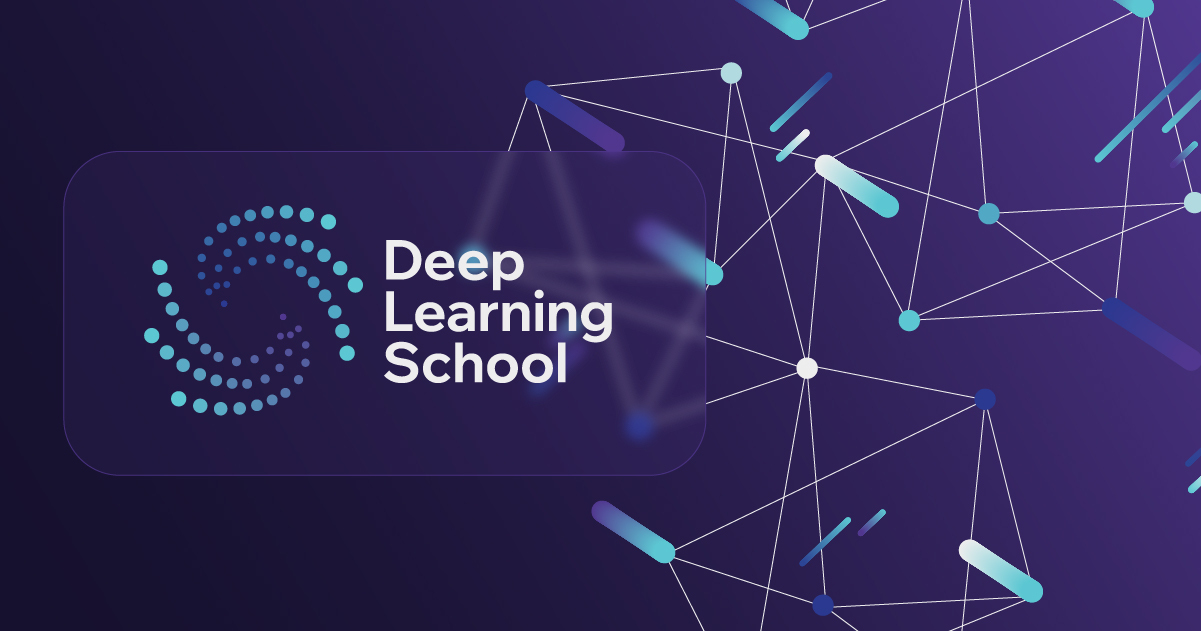


<h3 style="text-align: center;"><b>"Глубокое обучение". Продвинутый поток</b></h3>

<h1 style="text-align: center;"><b>Семинар. PyTorch. Оптимизаторы. </b></h1>


Обучим базовую CNN на CIFAR как в прошлом ноутбуке, далее будем добавлять optimizer Adam, а также weight decay (аналог регуляризации, но для сверточных сетей) и LR scheduling (уменьшение коэффициента в зависимости от эпохи)

In [ ]:
!pip install tqdm

In [ ]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets
from tqdm.notebook import tqdm
import random
import numpy as np
import torch

In [ ]:
# Зафиксируем сиды для воспроизводимости
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)

In [ ]:
# Выберем cuda или cpu
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

# Загрузка датасета

[CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) — это набор данных, состоящий из 60 000 цветных изображений размером $32 \times 32$ пикселя, разделённых на 10 классов (например, самолёты, автомобили, птицы, кошки и др.). Из них 50 000 изображений используются для обучения моделей, а 10 000 — для их тестирования. Этот датасет широко применяется в задачах компьютерного зрения и отлично подходит для экспериментов с PyTorch.


In [ ]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def get_dataloaders(batch_size):
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    trainset = datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              shuffle=True, num_workers=2)
    testset = datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             shuffle=False, num_workers=2)
    return trainloader, testloader

В PyTorch датасетом считается любой объект, для которого определены методы `__len__(self)` и `__getitem__(self, i)`.

# Код обучения

In [ ]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    train_losses = []
    val_losses = []
    valid_accuracies = []
    for epoch in range(epochs):
        model.train() # Set model to training mode
        loss_sum = 0
        for xb, yb in tqdm(train_dl):
            # Move data to the appropriate device
            xb, yb = xb.to(device), yb.to(device)

            # Forward pass
            preds = model(xb)
            loss = loss_func(preds, yb)

            # Accumulate loss
            loss_sum += loss.item()

            # Backpropagation
            loss.backward()
            opt.step()
            opt.zero_grad()
        train_losses.append(loss_sum / len(train_dl))

        model.eval() # set model in validation mode
        loss_sum = 0
        correct = 0
        num = 0
        # for validation we don't need calculate gradients
        # ! eval() mode doen't turn off gradients !
        with torch.no_grad():
            for xb, yb in valid_dl:
                xb, yb = xb.to(device), yb.to(device)
                probs = model(xb)
                loss_sum += loss_func(probs, yb).item()

                _, preds = torch.max(probs, axis=-1)
                correct += (preds == yb).sum().item()
                num += len(xb)

        val_losses.append(loss_sum / len(valid_dl))
        valid_accuracies.append(correct / num)

    return train_losses, val_losses, valid_accuracies

In [ ]:
def plot_trainig(train_losses, valid_losses, valid_accuracies):
    plt.figure(figsize=(12, 9))

    # Plot training and validation losses in the first subplot
    plt.subplot(2, 1, 1)
    plt.xlabel('epoch')
    plt.plot(train_losses, label='train_loss')
    plt.plot(valid_losses, label='valid_loss')
    plt.legend()

    # Plot validation accuracy in the second subplot
    plt.subplot(2, 1, 2)
    plt.xlabel('epoch')
    plt.plot(valid_accuracies, label='valid accuracy')
    plt.legend()

In [ ]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(3, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(16 * 6 * 6, 120)  # 5x5 image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Далее мы запускаем обучение модели:
- Определяем функцию потерь ([CrossEntropyLoss](https://colab.research.google.com/drive/1EOlgKwXSj9z7JqBl9sz2Xg-pfv2Xjw7e#scrollTo=RQygJ0ZHCgCK&line=2&uniqifier=1)) и оптимизатор ([SGD](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html) с параметрами $\text{lr}=0.001$ и $\text{momentum}=0.9$).
- Запускаем обучение модели на $10$ эпох с помощью функции `fit` и визуализируем результаты (графики потерь и точности) с помощью plot_training.

100%|██████████| 170M/170M [00:05<00:00, 30.8MB/s]


  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]

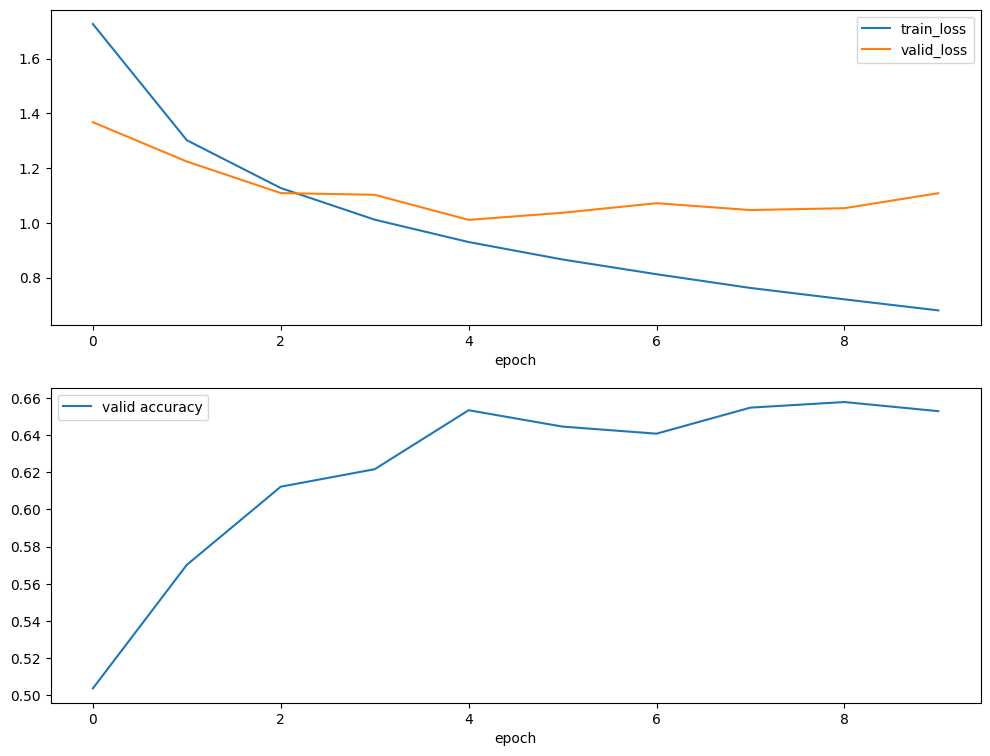

In [ ]:
model = Model().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

info = fit(10, model, criterion, optimizer, *get_dataloaders(4))
plot_trainig(*info)

Accuracy: ~0.65

# Adam

Это самый популярный оптимизатор для нейронных сетей. Если вам интересны сравнения разных алгоритмов, то можете почитать эту статью https://arxiv.org/abs/1609.04747.

### Adam, применение в PyTorch

  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]

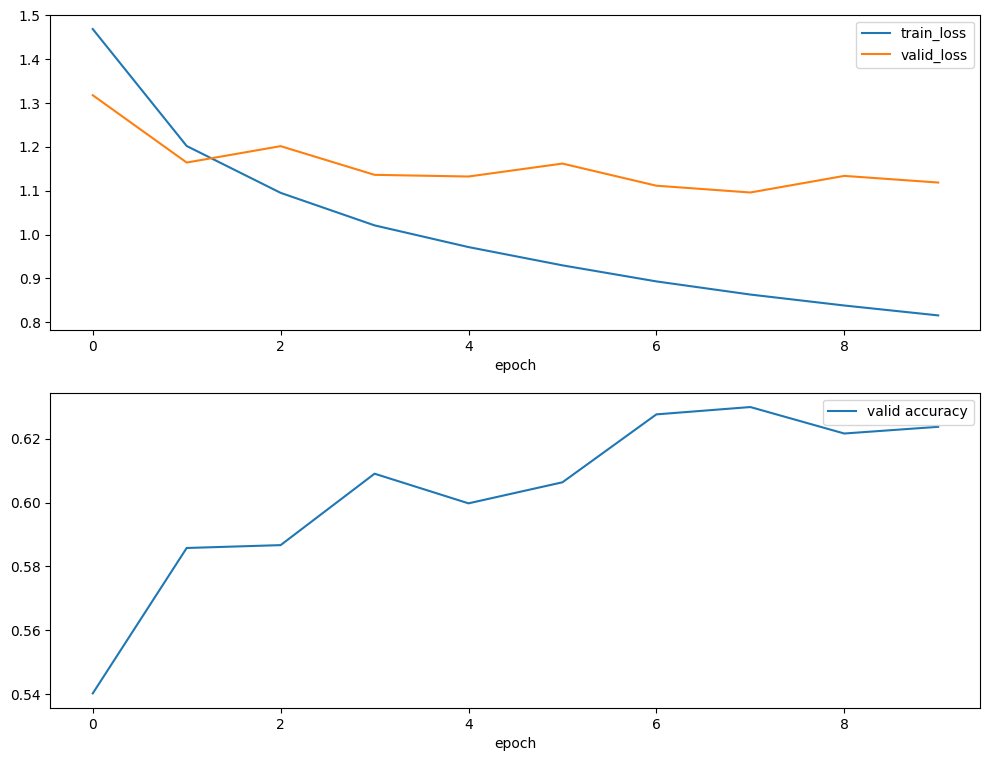

In [ ]:
model = Model().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))

info = fit(10, model, criterion, optimizer, *get_dataloaders(4))
plot_trainig(*info)

Accuracy: ~0.62

# Weight Decay

Для регуляризации линейных моделей мы прибавляли к лоссу сумму квадратов весов, умноженных на некоторый коэффициент:
$$L(\mathbf{w})=\sum_{i=1}^{l}\left(\mathbf{x}_{i}^{T} \mathbf{w}-y_{i}\right)^{2}+\beta \sum_{j=1}^{n} w_{j}^{2}$$

Для нейронных сетей мы можем выбрать такую же реугляризацию. Она называется WeightDecay. Во многие оптимизаторы можно передать параметр `weight_decay` и он будет являться коэффициентом, на который домножается сумма квадратовв весов.

Обычно используют `weight_decay=0.01` или `0.005`.

Если `weight_decay=0.01`, это значит, что все веса мы будем умножать на 0.99 перед каждым шагом градиентного спуска. И таким образом веса быстрее угасают

  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]

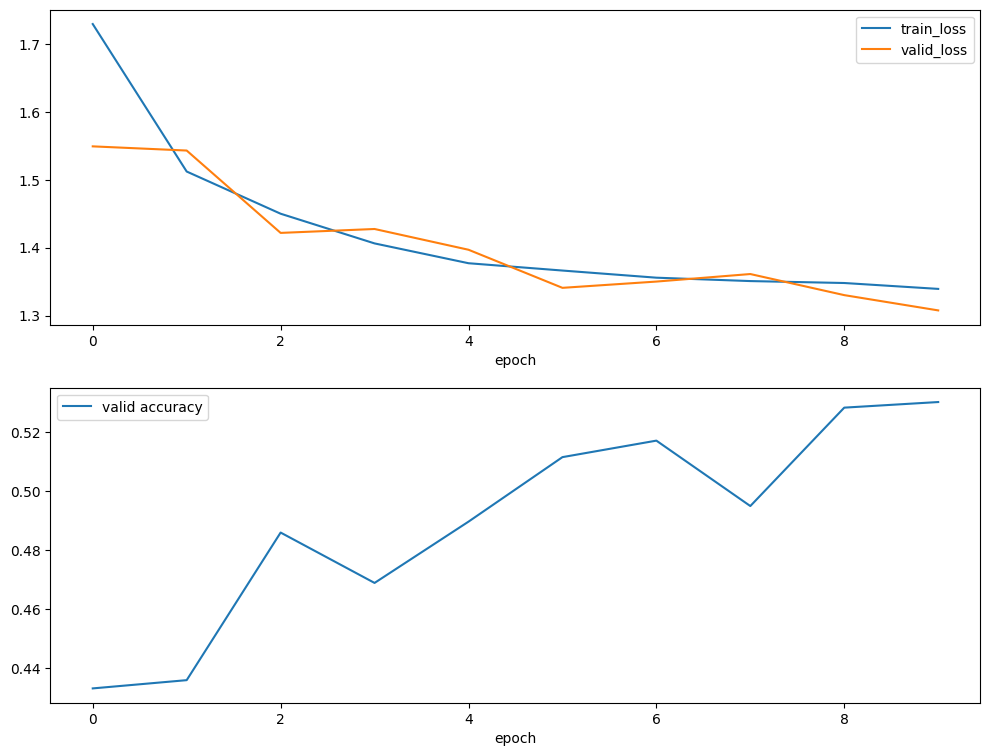

In [ ]:
model = Model().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), weight_decay=0.01)

info = fit(10, model, criterion, optimizer, *get_dataloaders(4))
plot_trainig(*info)

Accuracy: ~0.53

# LR scheduling

Часто мы хотим, чтобы наш learning rate как-то изменялся во время обучения. Стратегия, по которой мы будем изменять `lr` называется **lr scheduilng**.

Например, мы можем хотеть, чтобы learning_rate уменьшался с каждой эпохой в фиксированное число раз. Тогда в начале мы будем быстро двигаться к минимуму, а в конце точно не промахнемся мимо него за счет малых шагов. Такая стратегия называется LR Decay.

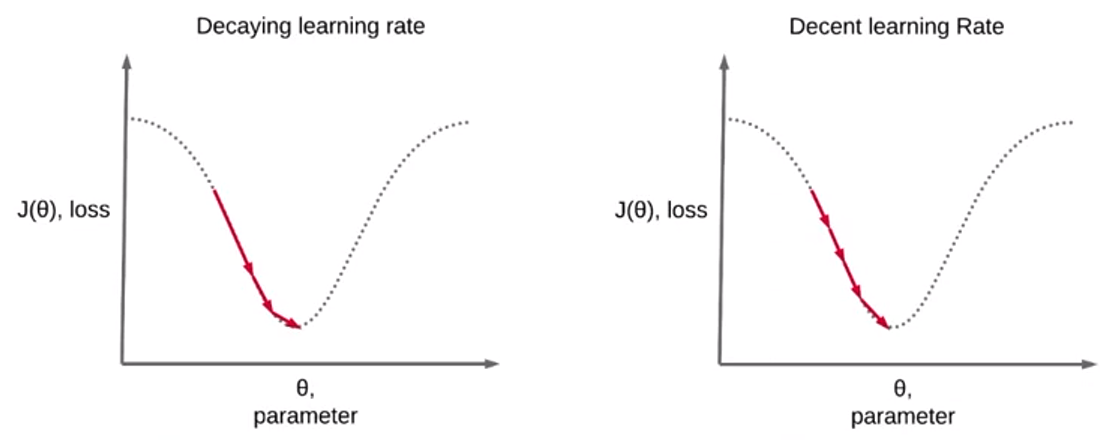

(Слева используется lr decay, справа нет. Слева мы можем не подбирать идеально точно lr и все равно со временем сойтись.)

Нам нужно немного изменить train loop

In [ ]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl, lr_sched=None):
    train_losses = []
    val_losses = []
    valid_accuracies = []
    for epoch in range(epochs):
        model.train()
        loss_sum = 0
        for xb, yb in tqdm(train_dl):
            xb, yb = xb.to(device), yb.to(device)
            loss = loss_func(model(xb), yb)
            loss_sum += loss.item()

            loss.backward()
            opt.step()
            opt.zero_grad()
        train_losses.append(loss_sum / len(train_dl))

        model.eval()
        loss_sum = 0
        correct = 0
        num = 0
        with torch.no_grad():
            for xb, yb in valid_dl:
                xb, yb = xb.to(device), yb.to(device)
                probs = model(xb)
                loss_sum += loss_func(probs, yb).item()

                _, preds = torch.max(probs, axis=-1)
                correct += (preds == yb).sum().item()
                num += len(xb)

        val_losses.append(loss_sum / len(valid_dl))
        valid_accuracies.append(correct / num)

        # CHANGES HERE
        lr_sched.step()
        # CHANGES END

    return train_losses, val_losses, valid_accuracies

  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]

  0%|          | 0/12500 [00:00<?, ?it/s]

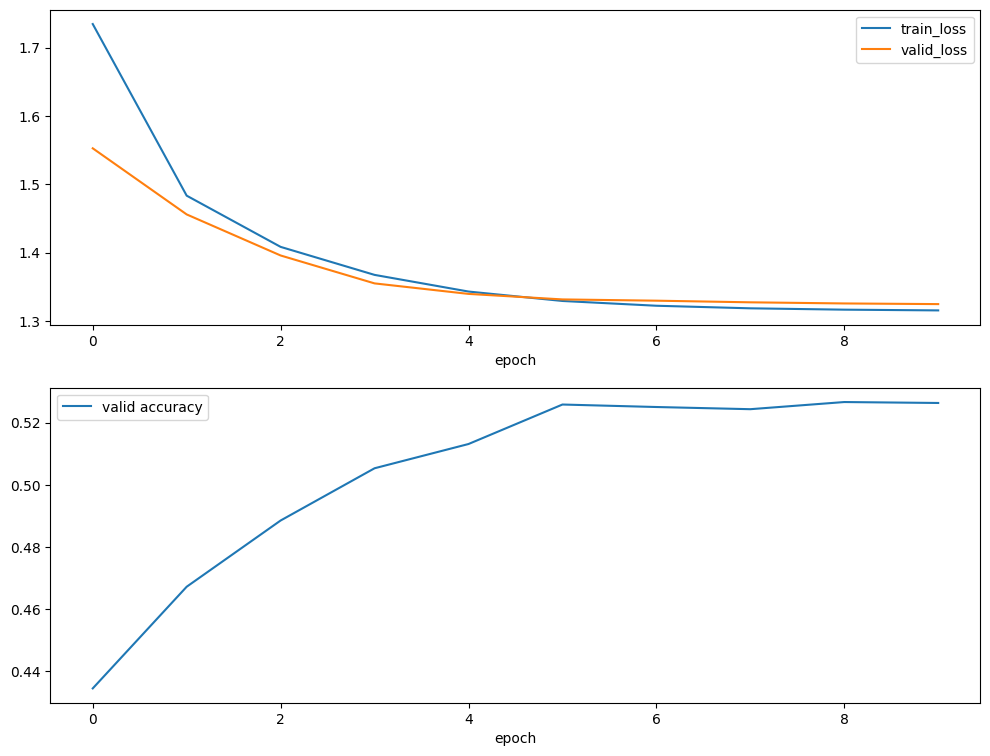

In [ ]:
model = Model().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), weight_decay=0.01)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.5)

info = fit(10, model, criterion, optimizer, *get_dataloaders(4), scheduler)
plot_trainig(*info)

Accuracy: ~0.53

Итого получаем:

Обычная модель: ~0.65

Adam: ~0.62

Adam + Weight Decay: ~0.53

Adam + Weight Decay + LR scheduling: ~0.53

Вообще получается, что результаты ухудшаются, но последние 2 результата можно сравнить: результаты одинаковые, но график стал более плавным, что логично

Тут скорее всего та же проблема - модель простая и такие нововведения могут быть избыточными для нее, а также недостаточное количество эпох

# Чекпоинтинг.

Есть очень хорошее официальное руководство: https://pytorch.org/tutorials/beginner/saving_loading_models.html.